# CIS 678 Project #3: Prediction

By: Hailey Siwek and Kyle Kane

### Introduction

For this project, the algorithm serves as a prediction system that encodes information from multimodal single-cell sequencing data, and the AI model we are training makes a prediction for one modality based on the information from the other modality. The developed multimodal deep learning algorithm integrates variational autoencoders (VAEs) and a multi-headed network using a Pytorch implementation to predict the antibodies binding to target proteins (anti-body-derived tags, ADT) from measuring the expression of all genes (RNA transcripts) simultaneously.

### Approach

The main approach taken for completion of this project was (1.) designing a multimodal AI model that results in a Kaggle Pearson correlation coefficient score greater than 0.7 to verify the model is functioning, (2.) tuning this model with a single headed network, and (3.) finally increasing the number of heads to create a multi-headed network.

1. Basic MMVAE Model

In creation of the basic multimodal variational autoencoder to integrate and learn latent reoresentations from RNA and ADT data, the approach can be defined as preprocessing and normalizing the data, designing the model architecture, developing a training strategy, and generating a predition. The RNA and ADT data sets were transposed, converted to be PyTorch tensors, min-max normalized for consitent feature scaling, and strutured for batch processing as PyTorch DataLoader objects. The model architecture involved the design of two independent encoders, one for the RNA and the other for the ADT, to pull out the latenet representations from the data sets and to ouput mean and variance values for reparameterization. The model architecture is also composed of two individual decoders, one for the RNA and the other for the ADT, that reconstruct the original inputs from the shared latent space. A VAE loss with an adjustable beta parameter was used to balance the MSE reconstruction loss with the KL divergence for latent space regularization. The training strategy was developed to train RNA and ADT on alternating epochs. The Adam optimizer was used, along with L2 weight decay, to ensure stable learning during training. The trained MMVAE model was then tasked with predicting ADT features from the RNA data by encoding, passing through the shared latent space, and decoding into ADT space.

2. Hyperparameter Tuning

Hyperparameters such as the number and size of layers, the latent dimension size, the number of epochs, the learning rate, the strength of dropout, the strength of the L2 weight decay, batch size, and later the number of heads required tuning to create the optimal algorithm for this project. Here it is important to note that a lower learning rate works better with a higher quantity of epochs and vice versa, but other parameters may tune based on all other hyperparameters or even independently. For hyperparameter tuning, 100 epochs was used for most tuning due to less execution time, and this corresponded well with a learning rate around 1e-3. The model was originally designed with two hidden layers of very minimal size with 128 being the largest size, and the latent dimension was originally set to 32. The strategy we employed was increasing each of these values after basic model implementation. Strength of dropout was experimented with from 0.1 to 0.5, and strength of L2 regularization weight decay was experimented with between 1e-3 to 1e-5. A batch size of 64 was first to be tested, and if the project timeline allowed, this metric was to be tuned.

3. Multi-Headed Network

The addition of a multi-headed network aims to process the latent space through multile linear transformations, layer norm, and add and norm, allowing for exploration of multiple local minima simultaneously. With the multi-headed network we also employed add and norm and layer norm, which fights against internal covariant shift. Tuning of the multi-headed network was conducted after basic hyperparameter tuning was completed to the most optimal condition. Experimentation for tuning this algorithm tested sizes between 1 and 150 heads. Increased heads increased also the computational cost.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNAEncoder(nn.Module):
    def __init__(self, input_dim=10000, latent_dim=None):
        super(RNAEncoder, self).__init__()
        self.dropout = nn.Dropout(0.2)
        # Increased sizes for all layers
        self.fc1 = nn.Linear(input_dim, 4096)  # Increased from 512 to 2048
        self.fc2 = nn.Linear(4096, 2048)       # Increased from 128 to 1024
        self.fc3 = nn.Linear(2048, 1024)        # Increased from 128 to 512
        self.fc_mu = nn.Linear(1024, latent_dim)  # Latent dim output
        self.fc_logvar = nn.Linear(1024, latent_dim)  # Latent dim output
        self.layer_norm = nn.LayerNorm(latent_dim)

    def forward(self, x):
        x = self.dropout(x)
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        mu = self.layer_norm(self.fc_mu(h))
        logvar = self.layer_norm(self.fc_logvar(h))
        return mu, logvar


class RNADecoder(nn.Module):
    def __init__(self, latent_dim=None, output_dim=10000):
        super(RNADecoder, self).__init__()
        # Increased sizes for all layers
        self.fc1 = nn.Linear(latent_dim, 1024)   # Increased from 128 to 512
        self.fc2 = nn.Linear(1024, 2048)         # Increased from 128 to 1024
        self.fc3 = nn.Linear(2048, 4096)        # Increased from 512 to 2048
        self.fc4 = nn.Linear(4096, output_dim)

    def forward(self, z):
        h = F.leaky_relu(self.fc1(z))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        return self.fc4(h)


class ADTEncoder(nn.Module):
    def __init__(self, input_dim=25, latent_dim=None):
        super(ADTEncoder, self).__init__()
        self.dropout = nn.Dropout(0.2)
        # Increased sizes for all layers
        self.fc1 = nn.Linear(input_dim, 1024)    # Increased from 64 to 512
        self.fc2 = nn.Linear(1024, 2048)         # Increased from 128 to 1024
        self.fc3 = nn.Linear(2048, 4096)        # Increased from 128 to 2048
        self.fc_mu = nn.Linear(4096, latent_dim)  # Latent dim output
        self.fc_logvar = nn.Linear(4096, latent_dim)  # Latent dim output
        self.layer_norm = nn.LayerNorm(latent_dim)

    def forward(self, x):
        x = self.dropout(x)
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        mu = self.layer_norm(self.fc_mu(h))
        logvar = self.layer_norm(self.fc_logvar(h))
        return mu, logvar


class ADTDecoder(nn.Module):
    def __init__(self, latent_dim=None, output_dim=25):
        super(ADTDecoder, self).__init__()
        # Increased sizes for all layers
        self.fc1 = nn.Linear(latent_dim, 1024)   # Increased from 128 to 512
        self.fc2 = nn.Linear(1024, 2048)         # Increased from 128 to 1024
        self.fc3 = nn.Linear(2048, 4096)        # Increased from 512 to 2048
        self.fc4 = nn.Linear(4096, output_dim)

    def forward(self, z):
        h = F.leaky_relu(self.fc1(z))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        return self.fc4(h)

class MultiHeadSharedModel(nn.Module):
    """Multi-headed shared model with residual connection and LayerNorm."""
    def __init__(self, latent_dim, num_heads=150):
        super(MultiHeadSharedModel, self).__init__()
        self.heads = nn.ModuleList([nn.Linear(latent_dim, latent_dim) for _ in range(num_heads)])
        self.concat_layer = nn.Linear(num_heads * latent_dim, latent_dim)
        self.layer_norm = nn.LayerNorm(latent_dim)  # LayerNorm after Add
        self.residual_fc = nn.Linear(latent_dim, latent_dim)  # For residual connection

    def forward(self, z):
        z_heads = [head(z) for head in self.heads]  # Compute outputs from all heads
        z_concat = torch.cat(z_heads, dim=-1)  # Concatenate along feature dimension
        z_out = self.concat_layer(z_concat)  # Reduce back to latent_dim

         #**Add & Norm**
        z_residual = self.residual_fc(z)  # Project original input to match shape
        z_final = self.layer_norm(z_out + z_residual)  # Add & Normalize

        return z_final


class MMVAE(nn.Module):
    """Multimodal VAE with RNA and ADT encoders/decoders and a shared model."""
    def __init__(self, rna_dim=10000, adt_dim=25, latent_dim=None, num_heads=150):
        super(MMVAE, self).__init__()
        self.rna_encoder = RNAEncoder(rna_dim, latent_dim)  # Corrected
        self.adt_encoder = ADTEncoder(adt_dim, latent_dim)  # Corrected
        self.shared_model = MultiHeadSharedModel(latent_dim, num_heads)
        self.rna_decoder = RNADecoder(latent_dim, rna_dim)  # Corrected
        self.adt_decoder = ADTDecoder(latent_dim, adt_dim)  # Corrected

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + eps * std"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, modality="rna"):
        if modality == "rna":
            mu, logvar = self.rna_encoder(x)
        else:
            mu, logvar = self.adt_encoder(x)

        z = self.reparameterize(mu, logvar)
        z_shared = self.shared_model(z)

        if modality == "rna":
            recon_x = self.rna_decoder(z_shared)
        else:
            recon_x = self.adt_decoder(z_shared)

        return recon_x, mu, logvar

# VAE Loss Function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """VAE Loss with adjustable beta parameter."""
    recon_loss = F.mse_loss(recon_x, x, reduction="mean")  # Reconstruction loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence

    return recon_loss + beta * kl_loss  # Apply β to KL term



(5000, 10000)
(5000, 25)


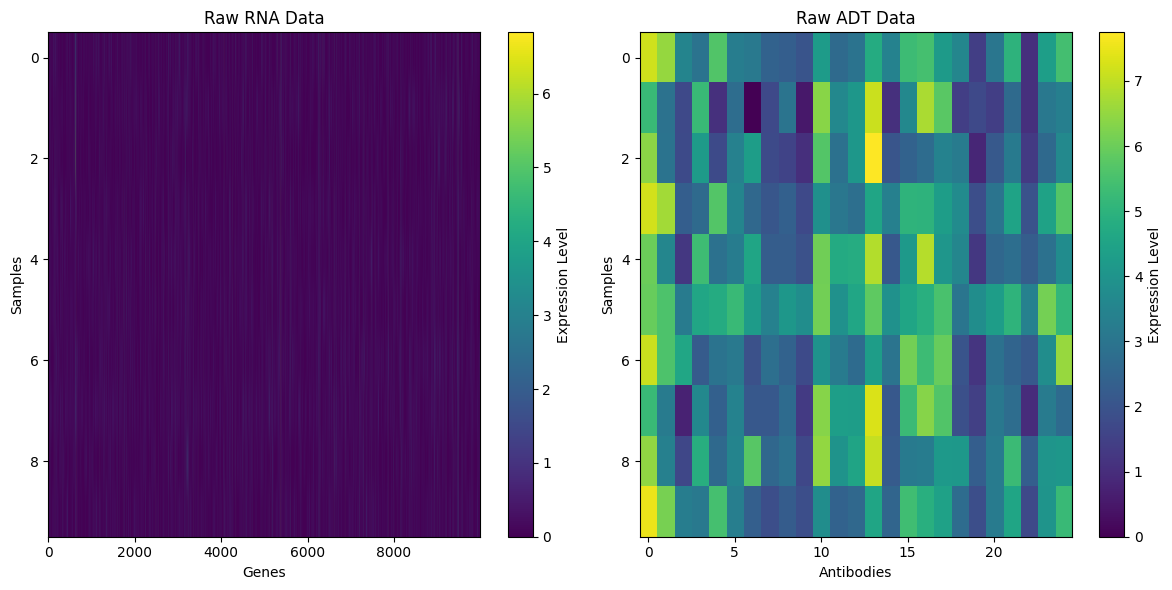

ADT Raw Data Min, Max: 0.0 8.123172


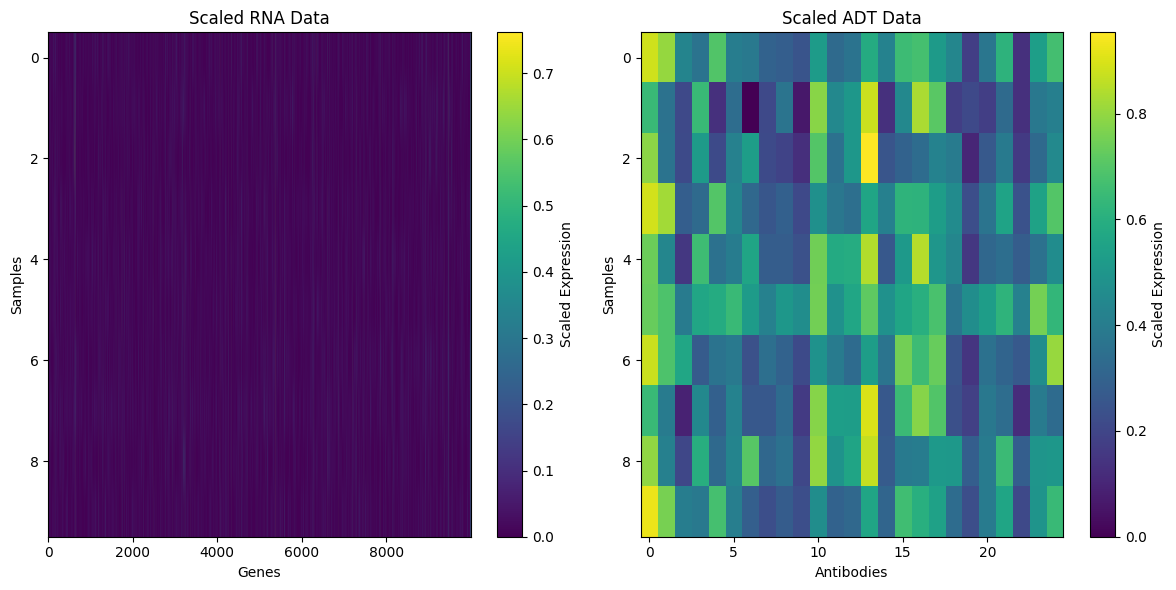

Scaled ADT Data Min, Max: 0.0 1.0


In [ ]:
# Normalize and Structure Data
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Plot Raw RNA and ADT Data
def plot_raw_data(rna_data, adt_data):
    plt.figure(figsize=(12, 6))

    # Plot RNA Data
    plt.subplot(1, 2, 1)
    plt.title("Raw RNA Data")
    plt.imshow(rna_data[:10], aspect="auto", cmap="viridis")
    plt.colorbar(label="Expression Level")
    plt.xlabel("Genes")
    plt.ylabel("Samples")

    # Plot ADT Data
    plt.subplot(1, 2, 2)
    plt.title("Raw ADT Data")
    plt.imshow(adt_data[:10], aspect="auto", cmap="viridis")
    plt.colorbar(label="Expression Level")
    plt.xlabel("Antibodies")
    plt.ylabel("Samples")

    plt.tight_layout()
    plt.show()

# Plot Scaled RNA and ADT Data
def plot_scaled_data(rna_data, adt_data):
    plt.figure(figsize=(12, 6))

    # Plot Scaled RNA Data
    plt.subplot(1, 2, 1)
    plt.title("Scaled RNA Data")
    plt.imshow(rna_data[:10], aspect="auto", cmap="viridis")
    plt.colorbar(label="Scaled Expression")
    plt.xlabel("Genes")
    plt.ylabel("Samples")

    # Plot Scaled ADT Data
    plt.subplot(1, 2, 2)
    plt.title("Scaled ADT Data")
    plt.imshow(adt_data[:10], aspect="auto", cmap="viridis")
    plt.colorbar(label="Scaled Expression")
    plt.xlabel("Antibodies")
    plt.ylabel("Samples")

    plt.tight_layout()
    plt.show()


# Load datasets
rna_df = pd.read_csv("train_RNA.csv").T
adt_df = pd.read_csv("train_ADT.csv").T
print(rna_df.shape)
print(adt_df.shape)

# Convert to NumPy arrays
rna_data = rna_df.values.astype(np.float32)
adt_data = adt_df.values.astype(np.float32)

# Plot raw data
plot_raw_data(rna_data, adt_data)
print("ADT Raw Data Min, Max:", adt_data.min(), adt_data.max())

# Normalize the data (Min-Max scaling)
rna_data = (rna_data - rna_data.min()) / (rna_data.max() - rna_data.min())
adt_data = (adt_data - adt_data.min()) / (adt_data.max() - adt_data.min())

# Plot scaled data
plot_scaled_data(rna_data, adt_data)
print("Scaled ADT Data Min, Max:", adt_data.min(), adt_data.max())

# Convert to PyTorch tensors
rna_tensor = torch.tensor(rna_data)
adt_tensor = torch.tensor(adt_data)

# Create PyTorch Datasets
rna_dataset = TensorDataset(rna_tensor)
adt_dataset = TensorDataset(adt_tensor)

# Create DataLoaders
batch_size = 64
rna_loader = DataLoader(rna_dataset, batch_size=batch_size, shuffle=True)
adt_loader = DataLoader(adt_dataset, batch_size=batch_size, shuffle=True)


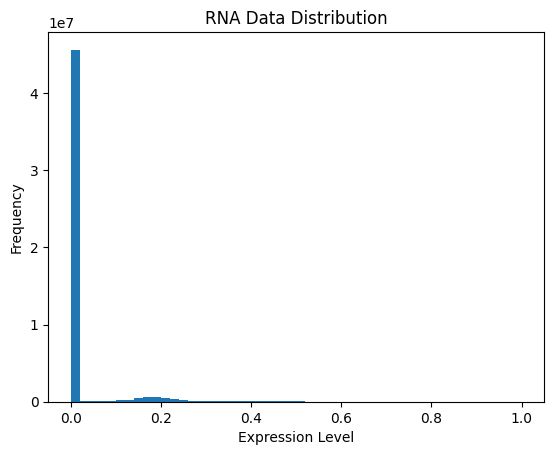

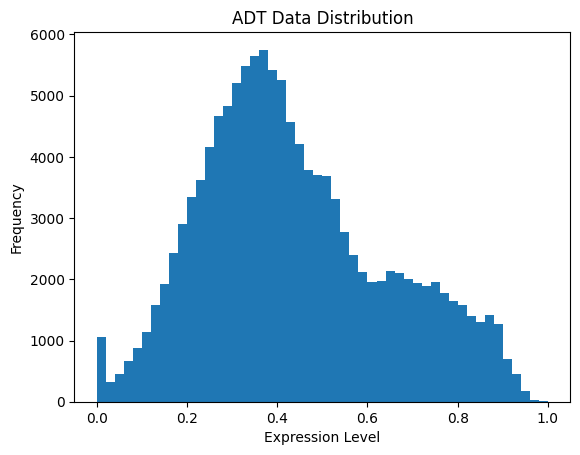

In [ ]:
#plot histogram of the data
import matplotlib.pyplot as plt


# 1) Plot histogram for RNA data
plt.figure()
# If rna_data is a 2D array, flatten it to 1D so each value is counted.
plt.hist(rna_data.flatten(), bins=50)
plt.title("RNA Data Distribution")
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.show()

# 2) Plot histogram for ADT data
plt.figure()
# Same approach for ADT data
plt.hist(adt_data.flatten(), bins=50)
plt.title("ADT Data Distribution")
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.show()

Epoch 1 [RNA Training], RNA Loss: 2744621.4431
Epoch 2 [ADT Training], ADT Loss: 2722901.5068
Epoch 3 [RNA Training], RNA Loss: 1721803.5771
Epoch 4 [ADT Training], ADT Loss: 1719954.9360
Epoch 5 [RNA Training], RNA Loss: 1116435.6129
Epoch 6 [ADT Training], ADT Loss: 1057315.4415
Epoch 7 [RNA Training], RNA Loss: 780443.9277
Epoch 8 [ADT Training], ADT Loss: 705786.4877
Epoch 9 [RNA Training], RNA Loss: 561877.2858
Epoch 10 [ADT Training], ADT Loss: 490573.1194
Epoch 11 [RNA Training], RNA Loss: 402688.5537
Epoch 12 [ADT Training], ADT Loss: 339791.2953
Epoch 13 [RNA Training], RNA Loss: 284932.5752
Epoch 14 [ADT Training], ADT Loss: 231259.9413
Epoch 15 [RNA Training], RNA Loss: 196388.6650
Epoch 16 [ADT Training], ADT Loss: 89367.1995
Epoch 17 [RNA Training], RNA Loss: 65210.6459
Epoch 18 [ADT Training], ADT Loss: 4457.0214
Epoch 19 [RNA Training], RNA Loss: 279.9467
Epoch 20 [ADT Training], ADT Loss: 203.5312
Epoch 21 [RNA Training], RNA Loss: 4.0805
Epoch 22 [ADT Training], ADT Lo

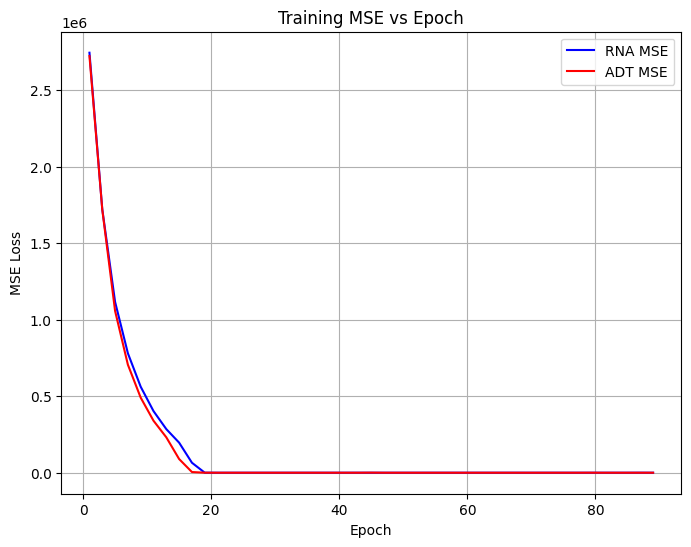

In [ ]:
# Design and Train model
import matplotlib.pyplot as plt
import seaborn as sns

# Model setup
rna_dim = rna_data.shape[1]  # RNA feature dimension
adt_dim = adt_data.shape[1]  # ADT feature dimension
latent_dim = 1024  # Latent space size
num_heads = 150  # Number of heads in the shared model

model = MMVAE(rna_dim, adt_dim, latent_dim, num_heads)
# L2 regularization (weight decay)
weight_decay = 1e-4  # Regularization strength
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)

# Initialize lists to store loss values
rna_losses = []
adt_losses = []

# Training loop
num_epochs = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    total_rna_loss, total_adt_loss = 0, 0

    if epoch % 2 == 0:  # Train RNA on even epochs
        for rna_batch in rna_loader:
            rna_batch = rna_batch[0].to(device)
            optimizer.zero_grad()
            recon_rna, mu_rna, logvar_rna = model(rna_batch, modality="rna")
            loss_rna = vae_loss(recon_rna, rna_batch, mu_rna, logvar_rna)
            loss_rna.backward()
            optimizer.step()
            total_rna_loss += loss_rna.item()

        rna_losses.append(total_rna_loss)
        print(f"Epoch {epoch+1} [RNA Training], RNA Loss: {total_rna_loss:.4f}")

    else:  # Train ADT on odd epochs
        for adt_batch in adt_loader:
            adt_batch = adt_batch[0].to(device)
            optimizer.zero_grad()
            recon_adt, mu_adt, logvar_adt = model(adt_batch, modality="adt")
            loss_adt = vae_loss(recon_adt, adt_batch, mu_adt, logvar_adt)
            loss_adt.backward()
            optimizer.step()
            total_adt_loss += loss_adt.item()

        adt_losses.append(total_adt_loss)
        print(f"Epoch {epoch+1} [ADT Training], ADT Loss: {total_adt_loss:.4f}")

    # Save the trained model
torch.save(model.state_dict(), "mmvae_model.pth")
print("Model saved successfully.")

# Plot Training MSE vs Epoch for RNA and ADT
def plot_training_losses(rna_losses, adt_losses):
    epochs = range(1, num_epochs+1, 2)  # For every second epoch

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, rna_losses, label="RNA MSE", color='blue')
    plt.plot(epochs, adt_losses, label="ADT MSE", color='red')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training MSE vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

# After training, plot the losses
plot_training_losses(rna_losses, adt_losses)

In [ ]:
# Load the model
model = MMVAE(rna_dim, adt_dim, latent_dim, num_heads)  # Recreate model structure
model.load_state_dict(torch.load("mmvae_model.pth"))
model.eval()  # Set model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
import torch
import numpy as np
import pandas as pd

def predict_adt_from_rna(model, test_rna_data, device='cpu'):
    """Pass RNA data through RNA Encoder → Shared Model → ADT Decoder to predict ADT."""
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        # Convert test RNA data to tensor and move to device
        test_rna_data = torch.tensor(test_rna_data, dtype=torch.float32).to(device)

        # Encode RNA into latent space
        mu, logvar = model.rna_encoder(test_rna_data)
        z = model.reparameterize(mu, logvar)  # Sample from latent space
        z_shared = model.shared_model(z)  # Pass through shared model

        # Decode to ADT features
        predicted_adt = model.adt_decoder(z_shared)  # Expected shape: (5000, 25)

    return predicted_adt.cpu().numpy().flatten()  # Flatten to shape (125,000,)

In [ ]:
# Test model and Generate submission file for ADT predictions
test_rna_df = pd.read_csv("test_RNA.csv").T

# Convert to NumPy arrays
test_rna_data = rna_df.values.astype(np.float32)

# Normalize the data (Min-Max scaling)
test_rna_data = (test_rna_data - test_rna_data.min()) / (test_rna_data.max() - test_rna_data.min())

# Convert to PyTorch tensors
test_rna_tensor = torch.tensor(test_rna_data)

# Create PyTorch Datasets
test_rna_dataset = TensorDataset(test_rna_tensor)

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predict ADT from RNA
predicted_adt = predict_adt_from_rna(model, test_rna_data, device)

# Ensure correct shape
print(predicted_adt.shape)  # Expected: (125000,)

# Create unique identifiers for each value
identifiers = [f"id{i+1}" for i in range(len(predicted_adt))]

# Save Predictions to CSV
predicted_adt_df = pd.DataFrame({'Id': identifiers, 'Expected': predicted_adt})
predicted_adt_df.to_csv("predicted_ADT.csv", index=False)

print("ADT prediction completed and saved to predicted_ADT.csv.")

(125000,)
ADT prediction completed and saved to predicted_ADT.csv.


### Results & Discussion

The basic MMVAE model was successfully implemented and acheived a Kaggle Pearson correlation coefficient score greater than 0.7. The final hyperparameters that were selected and created the best Kaggle score (Pearson correlation coefficient of 0.7338) upon submission are as follows:

*   Number of Hidden Layers: 3
*   Size of Layers: 1024, 2048, 4096
*   Latent Dimension Size: 1024
*   Number of Epochs: 90
*   Learning Rate: 1e-3
*   Strength of Dropout: 0.2
*   Strength of L2 Weight Decay: 1e-4
*   Number of Heads: 150
*   Batch Size: 64

The largest the latent dimension could be defined was the size fo the smallest layer. We chose to utilize the maximum latent dimension size according to the hidden layer sizes that were selected to be considerably large, reaching up to 4096. Moving from two to three hidden layers, significant improvement was observed in Kaggle score. However when experimenting with increasing to four, this trend did not follow, as no real change was observed in our algorithm's performance based on Kaggle score. The epoch value being near 100 and the learning rate being near 1e-3 performed well together, and other values that were experimented with performed significantly less well. This was a surprising result and is likely due to not cracking an adequate, corresponding combination of values here in the project timeline allotted. 0.2 consistently performed as the optimal amount of dropout to implement when testing at different points during tuning of the algorithm, and values set such as 0.5 performed significantly less well. The strength of the L2 weight decay also performed significantly well when set to 1e-4 but when changed to either 1e-3 or 1e-5 performed significantly less well. This likely may have needed experimentation of different values at smaller step sizes. Batch size was not truly tuned, as the project timeline we operated at did not allow. A batch size of 64 was utilized in our algorithm. The number of heads was tested at multiple values between 1 and 150. Changing from 1 to 150 heads we may have seen at most an increase of 0.0008 in the Kaggle Pearson correlation coefficient score, and less change would have correlated to a lesser increase in the score. The loss outputted for each epoch in the algorithm showed evidence of impact from internal covariant shift because the loss values for either the RNA or the ADT seemed to spike up unexpectedly every once in a while. If the project timeline allowed, we would have worked to decrease this occurance.

The Kaggle score of 0.7338 suggests that this algorithm is successfully capturing underlying patterns in the biological data but still has room for improvement. It is important to note that some difficulties with making predictions from biological data sets include high noise levels and inherent variability across living subjects.

### Conclusion

Overall, this AI model successfully implements a MMVAE that generates a prediction for ADT from RNA data. This algorithm resulted in a Kaggle Pearson correlation coefficient of 0.7338, which suggests the model performing adequately but not optimally. If further improvements were to be made to this model, they might include a calculation of Pearson correlation coefficient within cross validation internally in the algorithm for increased efficiency in evaluating model performance, further hyperparameter tuning and experimentation, and further experimentation of differing model architectures, residual connections for instance. We also would have aimed to tuned to find an increased number of epochs with a decreased learning rate, as this likely would have resulted in the model learning in more detail and generated a better prediction. Same reasoning lies in also aiming for perhaps an additional hidden layer and increasing layer sizes to accomodate a larger latent dimension space. If we had been able to create a well suited combination of hyperparameters as described, the algorithm performance likely would have increased, though the model operates successfully in this well tuned and reasoned MMVAE network.

### Appendix

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def negative_binomial_loss(x, mu, theta, eps=1e-8):

    # Make sure mu, theta are positive
    mu = torch.clamp(mu, min=eps)
    theta = torch.clamp(theta, min=eps)

    # We'll broadcast theta if it has shape [n_features]
    # Expand to match x and mu shape (batch_size, n_features).
    if theta.ndim == 1 and theta.size(0) == mu.size(1):
        theta = theta.unsqueeze(0)  # shape => (1, n_features)
    elif theta.ndim == 0:
        theta = theta.view(1, 1)  # single global dispersion

    # Negative log-likelihood
    # nll = -log p(x|mu,theta)
    term1 = torch.lgamma(x + theta) - torch.lgamma(theta) - torch.lgamma(x + 1)
    term2 = theta * torch.log(theta / (mu + theta) + eps)
    term3 = x * torch.log(mu / (mu + theta) + eps)
    nll = -(term1 + term2 + term3)

    # Return mean (or sum) over all elements
    return nll.mean()


class RNAEncoder(nn.Module):
    def __init__(self, input_dim=10000, latent_dim=128):
        super(RNAEncoder, self).__init__()
        self.dropout = nn.Dropout(0.3)

        # Smaller hidden sizes
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)

        self.layer_norm1 = nn.LayerNorm(1024)
        self.layer_norm2 = nn.LayerNorm(512)
        self.layer_norm3 = nn.LayerNorm(256)

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Final LN on latent
        self.layer_norm_mu = nn.LayerNorm(latent_dim)
        self.layer_norm_lv = nn.LayerNorm(latent_dim)

    def forward(self, x):
        x = self.dropout(x)
        h = F.leaky_relu(self.layer_norm1(self.fc1(x)))
        h = F.leaky_relu(self.layer_norm2(self.fc2(h)))
        h = F.leaky_relu(self.layer_norm3(self.fc3(h)))

        mu = self.layer_norm_mu(self.fc_mu(h))
        logvar = self.layer_norm_lv(self.fc_logvar(h))
        return mu, logvar


class ADTEncoder(nn.Module):
    def __init__(self, input_dim=25, latent_dim=128):
        super(ADTEncoder, self).__init__()
        self.dropout = nn.Dropout(0.3)

        # Smaller hidden sizes
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)  # can keep same final size

        self.layer_norm1 = nn.LayerNorm(512)
        self.layer_norm2 = nn.LayerNorm(256)
        self.layer_norm3 = nn.LayerNorm(256)

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Final LN on latent
        self.layer_norm_mu = nn.LayerNorm(latent_dim)
        self.layer_norm_lv = nn.LayerNorm(latent_dim)

    def forward(self, x):
        x = self.dropout(x)
        h = F.leaky_relu(self.layer_norm1(self.fc1(x)))
        h = F.leaky_relu(self.layer_norm2(self.fc2(h)))
        h = F.leaky_relu(self.layer_norm3(self.fc3(h)))

        mu = self.layer_norm_mu(self.fc_mu(h))
        logvar = self.layer_norm_lv(self.fc_logvar(h))
        return mu, logvar



class RNADecoder(nn.Module):
    def __init__(self, latent_dim=128, output_dim=10000):
        super(RNADecoder, self).__init__()
        # Learnable dispersion for each gene
        self.theta_rna = nn.Parameter(torch.zeros(output_dim))

        # Smaller hidden sizes
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, output_dim)

        self.layer_norm1 = nn.LayerNorm(256)
        self.layer_norm2 = nn.LayerNorm(512)
        self.layer_norm3 = nn.LayerNorm(1024)

    def forward(self, z):
        h = F.leaky_relu(self.layer_norm1(self.fc1(z)))
        h = F.leaky_relu(self.layer_norm2(self.fc2(h)))
        h = F.leaky_relu(self.layer_norm3(self.fc3(h)))
        raw = self.fc4(h)
        # Mu must be > 0, so we apply softplus
        mu = F.softplus(raw)
        return mu  # This is "mu" for NB


class ADTDecoder(nn.Module):
    def __init__(self, latent_dim=128, output_dim=25):
        super(ADTDecoder, self).__init__()
        # Learnable dispersion for each ADT feature
        self.theta_adt = nn.Parameter(torch.zeros(output_dim))

        # Smaller hidden sizes
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)

        self.layer_norm1 = nn.LayerNorm(256)
        self.layer_norm2 = nn.LayerNorm(256)
        self.layer_norm3 = nn.LayerNorm(512)

    def forward(self, z):
        h = F.leaky_relu(self.layer_norm1(self.fc1(z)))
        h = F.leaky_relu(self.layer_norm2(self.fc2(h)))
        h = F.leaky_relu(self.layer_norm3(self.fc3(h)))
        raw = self.fc4(h)
        mu = F.softplus(raw)
        return mu



class MultiHeadSharedModel(nn.Module):
    """Multi-headed shared model: sum of heads + residual + LayerNorm."""
    def __init__(self, latent_dim=128, num_heads=4):
        super(MultiHeadSharedModel, self).__init__()
        self.num_heads = num_heads
        self.heads = nn.ModuleList([nn.Linear(latent_dim, latent_dim) for _ in range(num_heads)])

        # Residual projection
        self.residual_fc = nn.Linear(latent_dim, latent_dim)
        self.layer_norm = nn.LayerNorm(latent_dim)

        # Optional dropout to improve regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, z):
        # Apply each head and sum the outputs
        z_heads = [head(z) for head in self.heads]
        z_sum = sum(z_heads)  # shape: (batch_size, latent_dim)

        # Residual connection
        z_residual = self.residual_fc(z)

        # Add & Norm
        z_out = self.layer_norm(self.dropout(z_sum) + z_residual)
        return z_out



class MMVAE(nn.Module):
    def __init__(self, rna_dim=10000, adt_dim=25, latent_dim=128, num_heads=4):
        super(MMVAE, self).__init__()
        self.rna_encoder = RNAEncoder(rna_dim, latent_dim)
        self.adt_encoder = ADTEncoder(adt_dim, latent_dim)

        self.shared_model = MultiHeadSharedModel(latent_dim, num_heads)

        self.rna_decoder = RNADecoder(latent_dim, rna_dim)
        self.adt_decoder = ADTDecoder(latent_dim, adt_dim)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, modality="rna"):
        # Encode
        if modality == "rna":
            mu, logvar = self.rna_encoder(x)
        else:
            mu, logvar = self.adt_encoder(x)

        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Shared multi-head transformation
        z_shared = self.shared_model(z)

        # Decode
        if modality == "rna":
            recon_mu = self.rna_decoder(z_shared)  # NB mean
        else:
            recon_mu = self.adt_decoder(z_shared)

        return recon_mu, mu, logvar


def vae_loss(recon_mu, x, mu, logvar, decoder, beta=1.0):

    # Retrieve the learned dispersion for the appropriate modality
    if isinstance(decoder, RNADecoder):
        theta = F.softplus(decoder.theta_rna)  # (n_features,) => broadcast
    else:
        theta = F.softplus(decoder.theta_adt)  # (n_features,)

    # NB Reconstruction loss
    recon_loss = negative_binomial_loss(x, recon_mu, theta)

    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kl_loss = kl_loss.mean()  # average over batch

    return recon_loss + beta * kl_loss


[Epoch 1 RNA] Loss: 12607.7584
[Epoch 11 RNA] Loss: 1691.9564
[Epoch 21 RNA] Loss: 879.1164
[Epoch 31 RNA] Loss: 788.1623
[Epoch 41 RNA] Loss: 727.8098
[Epoch 51 RNA] Loss: 680.5375
[Epoch 61 RNA] Loss: 638.1815
[Epoch 71 RNA] Loss: 615.0450
[Epoch 81 RNA] Loss: 764.1833
[Epoch 91 RNA] Loss: 516.4151
[Epoch 101 RNA] Loss: 476.6190
[Epoch 111 RNA] Loss: 440.2360
[Epoch 121 RNA] Loss: 412.2162
[Epoch 131 RNA] Loss: 381.2693
[Epoch 141 RNA] Loss: 346.7809
[Epoch 151 RNA] Loss: 307.7192
[Epoch 161 RNA] Loss: 260.2105
[Epoch 171 RNA] Loss: 233.2779
[Epoch 181 RNA] Loss: 206.1534
[Epoch 191 RNA] Loss: 176.6049
[Epoch 201 RNA] Loss: 139.9321
[Epoch 211 RNA] Loss: 110.6424
[Epoch 221 RNA] Loss: 91.6424
[Epoch 231 RNA] Loss: 75.4725
[Epoch 241 RNA] Loss: 62.2319
[Epoch 251 RNA] Loss: 47.6450
[Epoch 261 RNA] Loss: 67.8426
[Epoch 271 RNA] Loss: 59.3524
[Epoch 281 RNA] Loss: 62.6445
[Epoch 291 RNA] Loss: 61.7092
Model saved successfully.


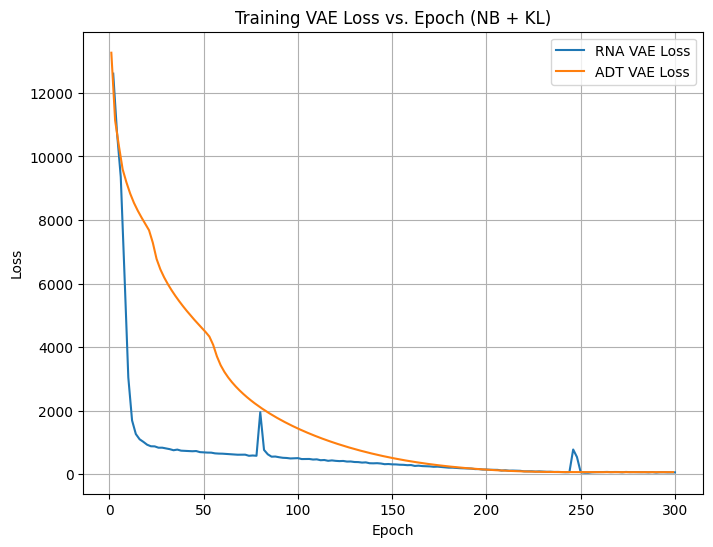

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

rna_dim = rna_data.shape[1]
adt_dim = adt_data.shape[1]
latent_dim = 128
num_heads = 100

model = MMVAE(rna_dim, adt_dim, latent_dim, num_heads)

# Use a device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# We'll store training losses
rna_losses = []
adt_losses = []

num_epochs = 300

for epoch in range(num_epochs):
    total_rna_loss = 0.0
    total_adt_loss = 0.0

    if epoch % 2 == 0:
        # Train on RNA
        for rna_batch in rna_loader:
            rna_batch = rna_batch[0].to(device)
            optimizer.zero_grad()
            recon_rna, mu_rna, logvar_rna = model(rna_batch, modality="rna")

            # IMPORTANT: pass the RNA decoder for NB parameters
            loss_rna = vae_loss(recon_rna, rna_batch, mu_rna, logvar_rna, model.rna_decoder)
            loss_rna.backward()
            optimizer.step()

            total_rna_loss += loss_rna.item()

        rna_losses.append(total_rna_loss)
        if epoch  % 10 == 0:
          print(f"[Epoch {epoch+1} RNA] Loss: {total_rna_loss:.4f}")

    else:
        # Train on ADT
        for adt_batch in adt_loader:
            adt_batch = adt_batch[0].to(device)
            optimizer.zero_grad()
            recon_adt, mu_adt, logvar_adt = model(adt_batch, modality="adt")

            # IMPORTANT: pass the ADT decoder for NB parameters
            loss_adt = vae_loss(recon_adt, adt_batch, mu_adt, logvar_adt, model.adt_decoder)
            loss_adt.backward()
            optimizer.step()

            total_adt_loss += loss_adt.item()

        adt_losses.append(total_adt_loss)
        #print(f"[Epoch {epoch+1} ADT] Loss: {total_adt_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "mmvae_model_nb.pth")
print("Model saved successfully.")

#Plot the data
def plot_training_losses(rna_losses, adt_losses):
    # For every second epoch (1-based indexing)
    rna_epochs = range(2, num_epochs+1, 2)
    adt_epochs = range(1, num_epochs+1, 2)

    plt.figure(figsize=(8, 6))
    plt.plot(rna_epochs, rna_losses, label="RNA VAE Loss")
    plt.plot(adt_epochs, adt_losses, label="ADT VAE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training VAE Loss vs. Epoch (NB + KL)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_losses(rna_losses, adt_losses)


In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset


rna_dim = 10000
adt_dim = 25
latent_dim = 128
num_heads = 96

# Instantiate the model
model = MMVAE(rna_dim, adt_dim, latent_dim, num_heads)

# Load the trained checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.load_state_dict(torch.load("mmvae_model_nb.pth", map_location=device))
model.to(device)
model.eval()


test_rna_df = pd.read_csv("test_RNA.csv")

test_rna_data = test_rna_df.values.astype(np.float32).T


data_min = test_rna_data.min()
data_max = test_rna_data.max()
test_rna_data = (test_rna_data - data_min) / (data_max - data_min + 1e-12)

# Convert to tensor
test_rna_tensor = torch.tensor(test_rna_data, dtype=torch.float32).to(device)


def predict_adt_from_rna(model, rna_tensor):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.rna_encoder(rna_tensor)
        z = model.reparameterize(mu, logvar)
        z_shared = model.shared_model(z)
        predicted_adt = model.adt_decoder(z_shared)  # => (num_samples, 25)
    return predicted_adt


predicted_adt = predict_adt_from_rna(model, test_rna_tensor)
predicted_adt_np = predicted_adt.cpu().numpy()

print("Predicted ADT shape:", predicted_adt_np.shape)

flattened_adt = predicted_adt_np.flatten()

identifiers = [f"id{i+1}" for i in range(len(flattened_adt))]
predicted_adt_df = pd.DataFrame({"Id": identifiers, "Expected": flattened_adt})
predicted_adt_df.to_csv("predicted_ADT.csv", index=False)
print("ADT prediction (flattened) saved to predicted_ADT.csv.")

Predicted ADT shape: (5000, 25)
ADT prediction (flattened) saved to predicted_ADT.csv.
